In [19]:
!pip install -q --upgrade "httpx[http2]" tqdm pandas matplotlib datasets


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [15]:
import httpx, json, textwrap, warnings
warnings.filterwarnings("ignore", message="Unverified HTTPS")

VLLM_URL = "https://llama3-vllm-vs-tgis.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
TGI_URL  = "https://llama3-default.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
PROMPT   = "Explain quantum entanglement in one sentence."
HEADERS  = {"Content-Type":"application/json"}

def discover(url, is_chat=True):
    attempts = [
        ("/v1/chat/completions", {
            "model": MODEL_ID,
            "messages":[{"role":"user","content":PROMPT}],
            "max_tokens": 64,
            "stream": False}),
        ("/v1/completions", {
            "model": MODEL_ID,
            "prompt": PROMPT,
            "max_tokens": 64,
            "stream": False}),
        ("/generate",{                       # raw vLLM
            "prompt": PROMPT,
            "n":1, "max_tokens":64})
    ]
    for path,payload in attempts:
        try:
            r=httpx.post(url+path,json=payload,headers=HEADERS,verify=False,timeout=20)
            if r.status_code==200:
                txt=(r.json()["choices"][0].get("message",{}).get("content")
                     or r.json()["choices"][0].get("text")
                     or r.json().get("text",""))
                print(f"\n🟢  {url}{path}\n"+textwrap.fill(txt,88))
                return path,payload
        except Exception: pass
    raise RuntimeError(f"No known completion path on {url}")

VLLM_PATH,VLLM_PAYLOAD = discover(VLLM_URL)
TGI_PATH, TGI_PAYLOAD  = discover(TGI_URL)



🟢  https://llama3-vllm-vs-tgis.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com/v1/chat/completions
Quantum entanglement is a phenomenon in which two or more particles become connected in
such a way that their properties, such as spin or momentum, become correlated and can be
instantaneously affected by actions on one particle, regardless of the distance between
them.

🟢  https://llama3-default.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com/v1/chat/completions
Quantum entanglement is a phenomenon in which two or more particles become connected in
such a way that their properties, such as position, momentum, or spin, become correlated
and linked, regardless of the distance between them, allowing instantaneous information
transfer.


In [16]:
import asyncio, time, statistics as st
from tqdm.auto import tqdm
import pandas as pd

N_WORKERS = 16
TEST_SECS = 30

async def _worker(base,path,payload,bag):
    async with httpx.AsyncClient(http2=True,verify=False,timeout=120) as c:
        stop=time.time()+TEST_SECS
        while time.time()<stop:
            t0=time.perf_counter()
            try:
                r=await c.post(base+path,json=payload,headers=HEADERS)
                dt=time.perf_counter()-t0
                if r.status_code==200:
                    tok=r.json().get("usage",{}).get("completion_tokens",0)
                    bag.append((dt,tok))
            except Exception: pass

async def bench(name,base,path,payload):
    bag=[]
    await asyncio.gather(*[_worker(base,path,payload,bag) for _ in range(N_WORKERS)])
    lats=[l for l,_ in bag]; toks=[t for _,t in bag]
    return dict(server=name,
                rps=round(len(lats)/TEST_SECS,1),
                tok_s=round(sum(toks)/TEST_SECS,1),
                p50=round(st.median(lats)*1000,1) if lats else None,
                p95=round(sorted(lats)[int(.95*len(lats))-1]*1000,1) if lats else None)

results=await asyncio.gather(
    bench("vLLM",VLLM_URL,VLLM_PATH,VLLM_PAYLOAD),
    bench("TGI", TGI_URL, TGI_PATH, TGI_PAYLOAD)
)
df=pd.DataFrame(results).set_index("server")
df


,rps,tok_s,p50,p95
server,,,,
vLLM,4.8,258.3,3522.0,3883.8
TGI,4.8,253.4,3619.4,4159.4


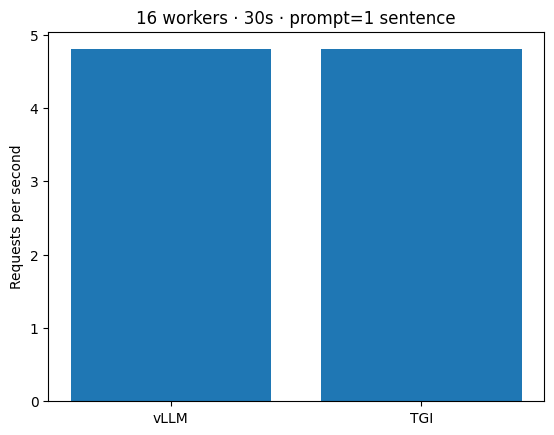

In [18]:
import matplotlib.pyplot as plt
plt.bar(df.index, df["rps"])
plt.ylabel("Requests per second")
plt.title(f"{N_WORKERS} workers · {TEST_SECS}s · prompt=1 sentence")
plt.show()
